In [329]:
import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import norm, gaussian_kde
from scipy.optimize import curve_fit, minimize
from scipy.signal import argrelextrema
from tqdm import tqdm
import uproot
import matplotlib.colors as colors
import sys
import pandas as pd



#Matplotlib formatting

rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [11, 8]
rcParams['font.size'] = 22
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['legend.fontsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

In [330]:
# LOAD DATA (npz files with waveform info per PMT, baseline already subtracted)

signal_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/waveform_npz/run2307"
pattern = re.compile(r"card(\d+)_slot(\d+)_ch(\d+)\.npz$")

run_number_str = os.path.basename(signal_dir)  # 'run2307'
run_number = int(re.search(r'\d+', run_number_str).group())
print(f"Run number: {run_number}")


available_combinations = []

for fname in os.listdir(signal_dir):
    match = pattern.match(fname)
    if match:
        card_id, slot_id, ch_id = map(int, match.groups())
        available_combinations.append((card_id, slot_id, ch_id))

print(f"Found {len(available_combinations)} valid waveform files.")


#------------------------------------------------------------------------------


card_id, slot_id, channel_id = random.choice(available_combinations)                      # random PMT with data
print(f"Randomly selected PMT: card={card_id}, slot={slot_id}, ch={channel_id}")

#card_id, slot_id, channel_id =102,22,0                                                   # particular PMT
#print(f"Selected PMT: card={card_id}, slot={slot_id}, ch={channel_id}")

pmt_label = f"card{card_id}_slot{slot_id}_ch{channel_id}"
signal_npz = os.path.join(signal_dir, pmt_label + ".npz")

def load_waveforms(npz_file):
    data = np.load(npz_file)
    return data["waveforms"]

signal_waveforms = load_waveforms(signal_npz)
print("Loaded signal waveforms:", signal_waveforms.shape)

Run number: 2307
Found 1567 valid waveform files.
Randomly selected PMT: card=93, slot=101, ch=17
Loaded signal waveforms: (17784, 64)


In [331]:
# FUNCTIONS

# Find peaks and integrate charges with WCTE given integration window for consistency!

def do_pulse_finding(waveform, debug=False):
    threshold = 20                                # distinguish between pulse and noise waveforms
    fIntegralPreceding = 4
    fIntegralFollowing = 2
    
    above_threshold = np.where(waveform[3:-2] > threshold)[0] + 3
    pulses_found = []
    last_index = 0
    
    for index in above_threshold:
        # local maximum conditions
        if (waveform[index] <= waveform[index-1]): continue
        if (waveform[index] < waveform[index+1]): continue
        if (waveform[index] <= waveform[index+2]): continue
        if (waveform[index] <= waveform[index-2]): continue
        
        # integral condition
        start = max(0, index - fIntegralPreceding)
        end = min(len(waveform), index + fIntegralFollowing + 1)
        integral = np.sum(waveform[start:end])
        if integral < threshold * 2:
            continue
        
        # minimum spacing conditions between pulses
        if (last_index > 0) and (index - last_index) <= 20:
            continue
        
        pulses_found.append(index)
        last_index = index
    
    return pulses_found


def charge_calculation_mPMT_method(wf, peak_sample):
    n = len(wf)
    if peak_sample < 5 or peak_sample + 2 >= n:
        pass
    start = max(0, peak_sample - 5)
    end = min(n, peak_sample + 2)
    charge = np.sum(wf[start:end])
    if peak_sample + 2 < n and wf[peak_sample + 2] > 0:
        charge += wf[peak_sample + 2]
    return charge


#  Unbinned Gaussian negative log-likelihood
def nll_gauss(params, data):
    mu, sigma = params
    if sigma <= 0:
        return np.inf
    pdf = norm.pdf(data, mu, sigma)
    pdf = np.clip(pdf, 1e-12, None)
    return -np.sum(np.log(pdf))


def fit_gaussian_with_bounds(data, mu0, sigma0, sigma_bounds):

    N = len(data)
    A0 = N
    bounds = [(-np.inf, np.inf), sigma_bounds, (1, np.inf)]  # μ free, σ limited, A > 0

    def nll(params):
        mu, sigma, A = params
        if sigma <= 0 or A <= 0:
            return np.inf
        pdf = A * norm.pdf(data, mu, sigma)
        return -np.sum(np.log(pdf.clip(min=1e-12)))

    res = minimize(nll, [mu0, sigma0, A0], method="L-BFGS-B", bounds=bounds)
    if not res.success:
        raise RuntimeError("Gaussian fit failed")

    mu_fit, sigma_fit, A_fit = res.x
    err_mu = sigma_fit / np.sqrt(N)
    err_sigma = sigma_fit / np.sqrt(2*N)

    return dict(mu=mu_fit, 
                sigma=sigma_fit, 
                A=A_fit,
                err_mu=err_mu, 
                err_sigma=err_sigma, n=N
                )


def fit_pedestal_and_spe(charges, label="PMT", plot=True):

    x = np.asarray(charges)
    if len(x) < 80:
        raise RuntimeError("Too few points to identify pedestal + SPE peaks reliably")

    #   KDE and peak finding
    xs = np.linspace(np.min(x), np.max(x), 2500)
    kde = gaussian_kde(x)
    ys = kde(xs)

    peak_idx = argrelextrema(ys, np.greater)[0]
    if len(peak_idx) < 2:
        raise RuntimeError("Only one peak found - cannot separate pedestal and SPE")

    # Peak inside expected SPE charge range (ADC·ns)

    """"For safety, we manually set this region because some PMTs may have unusual noise
      waveforms far from 0 ADC counts. This can create a peak between the pedestal and 
      the 1PE peak, which I guess is due to noise. We want to avoid the fit falling in that region."""

    expected_spe_min = 100.0   
    expected_spe_max = 200.0  

    peak_xs = xs[peak_idx]
    peak_ys = ys[peak_idx]

    spe_candidates_mask = (peak_xs >= expected_spe_min) & (peak_xs <= expected_spe_max)
    spe_candidates_idx = np.where(spe_candidates_mask)[0]

    if len(spe_candidates_idx) >= 1:
        # Choose the strongest SPE peak inside the expected range
        chosen_spe_rel = spe_candidates_idx[np.argmax(peak_ys[spe_candidates_idx])]
        spe_center = peak_xs[chosen_spe_rel]

        # pedestal = lowest-charge remaining peak
        other_idx = [i for i in range(len(peak_xs)) if i != chosen_spe_rel]
        if len(other_idx) == 0:
            raise RuntimeError("Could not identify pedestal peak after SPE selection.")
        ped_center = peak_xs[other_idx[np.argmin(peak_xs[other_idx])]]

    else:
        # Fallback: original behaviour - two strongest peaks 
        idx_sorted = peak_idx[np.argsort(ys[peak_idx])][-2:]
        idx_sorted = np.sort(idx_sorted)
        ped_center = xs[idx_sorted[0]]
        spe_center = xs[idx_sorted[1]]

    # Regions where to fit based on the peaks found
    ped_mask = np.abs(x - ped_center) < 6
    if ped_mask.sum() < 20:
        ped_mask = np.abs(x - ped_center) < 10
    ped_data = x[ped_mask]

    sep = abs(spe_center - ped_center)
    spe_hw = max(40, 0.35 * sep)
    spe_mask = np.abs(x - spe_center) < spe_hw
    if spe_mask.sum() < 30:
        spe_mask = np.abs(x - spe_center) < (1.6 * spe_hw)
    spe_data = x[spe_mask]

    if len(spe_data) < 20:
        raise RuntimeError("Not enough points near the SPE peak for a stable fit.")

    # Gaussian fits (separately for the pedestal and for the SPE peak)
    pedestal_fit = fit_gaussian_with_bounds(ped_data,np.median(ped_data),np.std(ped_data) if ped_data.std() > 0 else 1.0,(0.1, 2.0))
    spe_fit = fit_gaussian_with_bounds(spe_data,np.median(spe_data),max(20, np.std(spe_data)),(10, 150))

    # gain and gain_error
    gain = spe_fit["mu"] - pedestal_fit["mu"]
    err_gain = np.sqrt(pedestal_fit["err_mu"]**2 + spe_fit["err_mu"]**2)

    result = dict(
        pedestal=pedestal_fit,
        spe=spe_fit,
        gain=gain,
        err_gain=err_gain,
        n_ped=len(ped_data),
        n_spe=len(spe_data)
    )

   
    # Plot
    if plot:
        bins = np.linspace(np.min(x), np.max(x), 500)
        bc = 0.5*(bins[1:]+bins[:-1])
        bw = bins[1] - bins[0]

        fig, ax = plt.subplots(figsize=(9,6), dpi=150)
        ax.hist(x, bins=bins, histtype="step", color="black", lw=1, label="Data")

        ped_pdf = pedestal_fit["n"] * norm.pdf(bc, pedestal_fit["mu"], pedestal_fit["sigma"]) * bw
        spe_pdf  = spe_fit["n"] * norm.pdf(bc,  spe_fit["mu"],  spe_fit["sigma"]) * bw

        ax.plot(bc, ped_pdf, "b--", lw=1.5, label=f"Pedestal μ={pedestal_fit['mu']:.2f}, σ={pedestal_fit['sigma']:.2f}, N={len(ped_data)}")
        ax.plot(bc, spe_pdf,  "g--", lw=1.5, label=f"SPE μ={spe_fit['mu']:.2f}, σ={spe_fit['sigma']:.2f}, N={len(spe_data)}")
        ax.plot(bc, ped_pdf + spe_pdf, "r", lw=1, alpha=0.7, label=f"Sum (Gain = {gain:.2f} ± {err_gain:.2f})")

        ax.set_xlim(-20, 500)
        ax.set_ylim(0, 300)
        ax.set_xlabel("Integrated charge [ADC·ns]")
        ax.set_ylabel(f"counts / {bw:.2f} ADC·ns")
        ax.set_title(f"Run {run_number} - PMT {pmt_label}: Unbinned Gaussian fit for seeds")
        ax.grid(alpha=0.3)
        ax.legend(fontsize=rcParams['legend.fontsize'])
        plt.show()


    return result

# STEP 2: Binned two-Gaussian fits using seeds and limited regions

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))


def fit_and_plot_gaussians(charges, seeds, bins=500):
    x = np.asarray(charges)

    # histogram --> binned
    fig, ax = plt.subplots(figsize=(9,6), dpi=150)
    counts, bin_edges, _ = ax.hist(x, bins=bins, histtype='step', color='black', linewidth=1.2, label='Data')
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

    # Pedestal fit
    mu_seed = seeds['pedestal']['mu']
    sigma_seed = seeds['pedestal']['sigma']
    n_seed  = seeds['pedestal']['n']

    ped_mask = (bin_centers >= mu_seed - 3*sigma_seed) & (bin_centers <= mu_seed + 3*sigma_seed)
    x_fit_ped = bin_centers[ped_mask]
    y_fit_ped = counts[ped_mask]

    p0_ped = [n_seed, mu_seed, sigma_seed]
    bounds_ped = ([0, mu_seed - 5*sigma_seed, 0.05], [np.inf, mu_seed + 5*sigma_seed, 5.0])
    params_ped, _ = curve_fit(gaussian, x_fit_ped, y_fit_ped, p0=p0_ped, bounds=bounds_ped, maxfev=20000)
    A_ped, mu_ped, sigma_ped = params_ped

    # SPE fit
    mu_spe_seed = seeds['spe']['mu']
    sigma_spe_seed = seeds['spe']['sigma']
    n_spe_seed = seeds['spe']['n']

    spe_mask = (bin_centers >= mu_spe_seed - 2*sigma_spe_seed) & (bin_centers <= mu_spe_seed + 2*sigma_spe_seed)
    x_fit_spe = bin_centers[spe_mask]
    y_fit_spe = counts[spe_mask]

    p0_spe = [n_spe_seed, mu_spe_seed, sigma_spe_seed]
    bounds_spe = ([0, mu_spe_seed - 3*sigma_spe_seed, 0.1], [np.inf, mu_spe_seed + 3*sigma_spe_seed, 80.0])
    params_spe, _ = curve_fit(gaussian, x_fit_spe, y_fit_spe, p0=p0_spe, bounds=bounds_spe, maxfev=20000)
    A_spe, mu_spe, sigma_spe = params_spe

    # Gain and gain_error
    gain = mu_spe - mu_ped
    N_ped = len(x[(x >= mu_seed - 3*sigma_seed) & (x <= mu_seed + 3*sigma_seed)])
    N_spe = len(x[(x >= mu_spe_seed - 2*sigma_spe_seed) & (x <= mu_spe_seed + 2*sigma_spe_seed)])
    err_gain = np.sqrt(sigma_ped**2 / N_ped + sigma_spe**2 / N_spe)

    # chi2/ndof for the SPE region
    chi2_spe = np.sum((y_fit_spe - gaussian(x_fit_spe, *params_spe))**2 / (y_fit_spe + 1))
    ndof_spe = len(y_fit_spe) - 3
    chi2ndof_spe = chi2_spe / ndof_spe if ndof_spe > 0 else np.nan

    # Plot
    x_full = np.linspace(-20, 500, 2000)

    ax.plot(x_fit_ped, gaussian(x_fit_ped, *params_ped), 'b--', lw=2, label=f"Pedestal μ={mu_ped:.2f}, σ={sigma_ped:.2f}, N={N_ped}")
    ax.plot(x_fit_spe, gaussian(x_fit_spe, *params_spe), 'g--', lw=2, label=f"SPE μ={mu_spe:.2f}, σ={sigma_spe:.2f}, N={N_spe}")
    ax.plot(x_full, gaussian(x_full, *params_ped) + gaussian(x_full, *params_spe), 'r-', lw=0.7, label=f"Sum (Gain={gain:.2f} ± {err_gain:.2f})")

    ax.axvspan(x_fit_ped[0], x_fit_ped[-1], color='blue', alpha=0.08)
    ax.axvspan(x_fit_spe[0], x_fit_spe[-1], color='green', alpha=0.08)

    # χ²/ndof text above SPE region
    ypos = max(gaussian(x_fit_spe, *params_spe)) * 1.1
    xpos = 0.5*(x_fit_spe[0] + x_fit_spe[-1])
    ax.text(xpos, ypos, f"χ²/ndof SPE = {chi2ndof_spe:.2f}", color='green', fontsize=rcParams['legend.fontsize'], ha='center', va='center')

    ax.set_xlim(-50, 500)
    ax.set_ylim(0, 300)
    ax.set_xlabel("Integrated charge [ADC·ns]")
    ax.set_ylabel(f"counts / {bw:.2f} ADC·ns")
    ax.set_title(f"Run {run_number} - PMT {pmt_label}: Binned two separate Gaussian fit")
    ax.grid(alpha=0.3)
    ax.legend()
    plt.show()

    # Dictionary with results
    return dict(
        pedestal=(mu_ped, sigma_ped, A_ped),
        spe=(mu_spe, sigma_spe, A_spe, chi2ndof_spe),
        gain=(gain, err_gain),
        N_ped=N_ped,
        N_spe=N_spe,
        ped_region=(x_fit_ped[0], x_fit_ped[-1]),
        spe_region=(x_fit_spe[0], x_fit_spe[-1])
    )


In [332]:
# ANALYSIS AND PLOTS

all_peaks = [do_pulse_finding(wf) for wf in signal_waveforms]
pulse_mask = np.array([len(p) > 0 for p in all_peaks])
noise_mask = ~pulse_mask

charges = []
peak_values = []

pulse_count = np.sum(pulse_mask)
noise_count = np.sum(noise_mask)

for wf, peaks in tqdm(zip(signal_waveforms, all_peaks), desc="Integrating all waveforms", total=len(signal_waveforms)):
    if len(peaks) > 0:
        peak_sample = peaks[0]    # pulse waveform
    else:
        peak_sample = np.argmax(wf)  # noise waveform

    q = charge_calculation_mPMT_method(wf, peak_sample)
    charges.append(q)
    peak_values.append(wf[peak_sample])

charges = np.array(charges)
peak_values = np.array(peak_values)
total_waveforms = len(signal_waveforms)
pulse_ratio = pulse_count / total_waveforms
mu = -np.log(1 - pulse_ratio)       # mean of Poisson statistics

print(f"Total waveforms processed: {total_waveforms}")
print(f"Pulses detected (LED): {pulse_count}")
print(f"Noise-only waveforms (pedestal): {noise_count}")
print(f"Pulse-to-LED flash ratio: {pulse_ratio:.4f} ({pulse_ratio*100:.2f}%)")
print(f"Mean number of photoelectrons per LED flash (mu): {mu:.4f}")   #if <<1, we are OK; if ~1, almost every flash would produce a pulse (saturated!)

Integrating all waveforms: 100%|████████████████████████████████████████████████████████████████████████████████| 17784/17784 [00:00<00:00, 48502.62it/s]

Total waveforms processed: 17784
Pulses detected (LED): 2644
Noise-only waveforms (pedestal): 15140
Pulse-to-LED flash ratio: 0.1487 (14.87%)
Mean number of photoelectrons per LED flash (mu): 0.1610


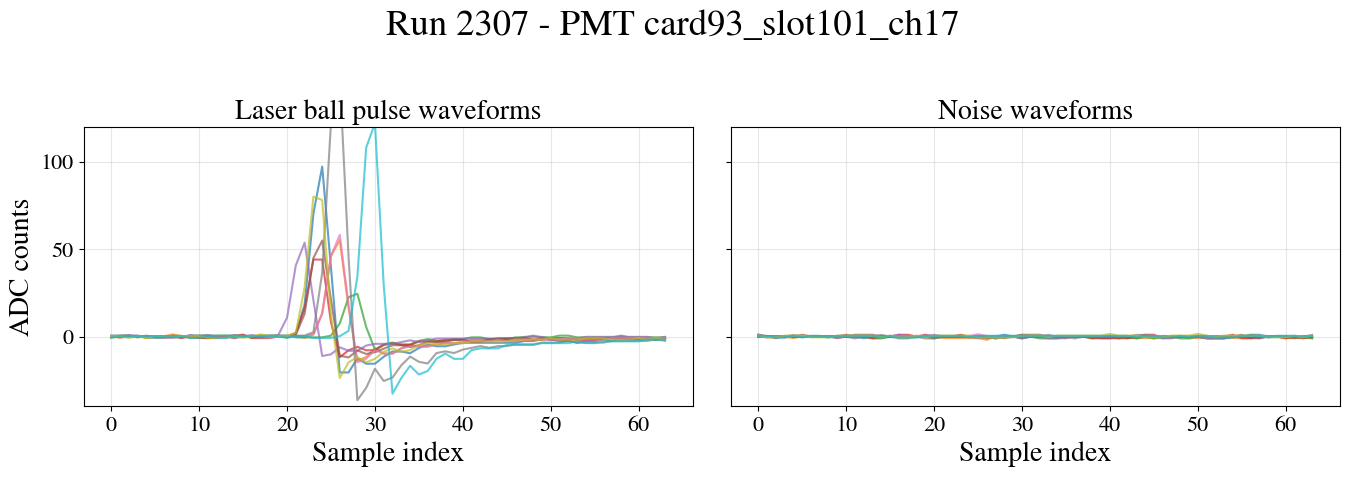

In [333]:
pulse_mask = np.zeros(len(charges), dtype=bool)
noise_mask = np.zeros(len(charges), dtype=bool)

index = 0
for wf in signal_waveforms:
    peaks = do_pulse_finding(wf)
    if len(peaks) > 0:
        pulse_mask[index] = True
    else:
        noise_mask[index] = True
    index += 1

# 10 random waveforms for each data set
pulse_indices = np.random.choice(np.where(pulse_mask)[0], size=min(10, np.sum(pulse_mask)), replace=False)
noise_indices = np.random.choice(np.where(noise_mask)[0], size=min(10, np.sum(noise_mask)), replace=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for idx in pulse_indices:
    axes[0].plot(signal_waveforms[idx], alpha=0.7)    #drawstyle="steps-mid"
axes[0].set_title(f"Laser ball pulse waveforms")
axes[0].set_xlabel("Sample index")
axes[0].set_ylabel("ADC counts")
axes[0].grid(True, alpha=0.3)

for idx in noise_indices:
    axes[1].plot(signal_waveforms[idx], alpha=0.7)
axes[1].set_title(f"Noise waveforms")
axes[1].set_xlabel("Sample index")
axes[1].grid(True, alpha=0.3)

plt.suptitle(f"Run {run_number} - PMT {pmt_label}")
plt.ylim(-40,120)
plt.tight_layout()
plt.show()

/dipc/elena/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # This is added back by InteractiveShellApp.init_path()


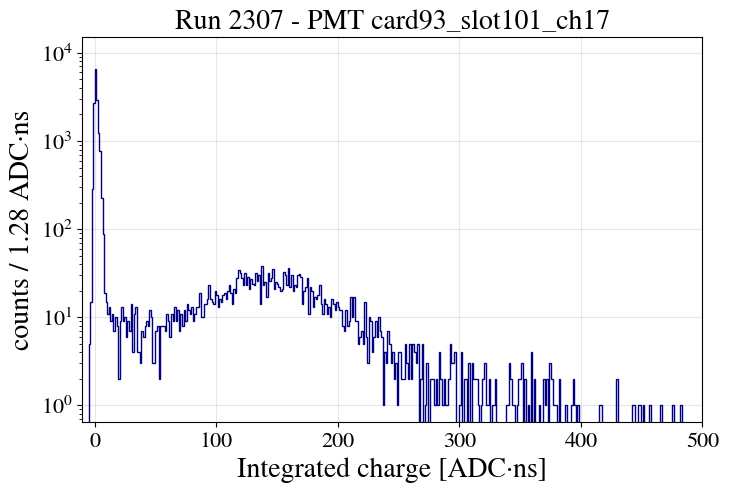

Pulse waveforms: 2644 | Noise waveforms: 15140


/dipc/elena/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


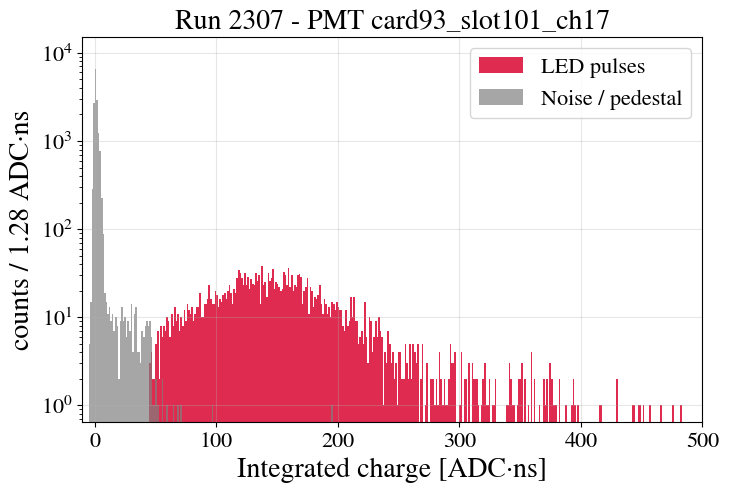

1.2807615230460923


In [334]:
bins = np.linspace(charges.min(), charges.max(), 500)
bw = bins[1] - bins[0]

#total charge distribution (integrated charge)
plt.figure(figsize=(8,5))
plt.hist(charges, bins=bins, histtype='step', color='navy')
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel(f"counts / {bw:.2f} ADC·ns")
plt.yscale("log")
plt.xlim(-10, 500)
plt.ylim(0,15000)
plt.title(f"Run {run_number} - PMT {pmt_label}")
plt.grid(True, alpha=0.3)
plt.show()


pulse_mask = np.array([len(p) > 0 for p in all_peaks])
noise_mask = ~pulse_mask

print(f"Pulse waveforms: {np.sum(pulse_mask)} | Noise waveforms: {np.sum(noise_mask)}")

plt.figure(figsize=(8,5))
plt.hist(charges[pulse_mask], bins=bins, color='crimson', alpha=0.9, label='LED pulses')
plt.hist(charges[noise_mask], bins=bins, color='gray', alpha=0.7, label='Noise / pedestal')
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel(f"counts / {bw:.2f} ADC·ns")
plt.yscale("log")
plt.xlim(-10, 500)
plt.ylim(0,15000)
plt.title(f"Run {run_number} - PMT {pmt_label}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(bw)

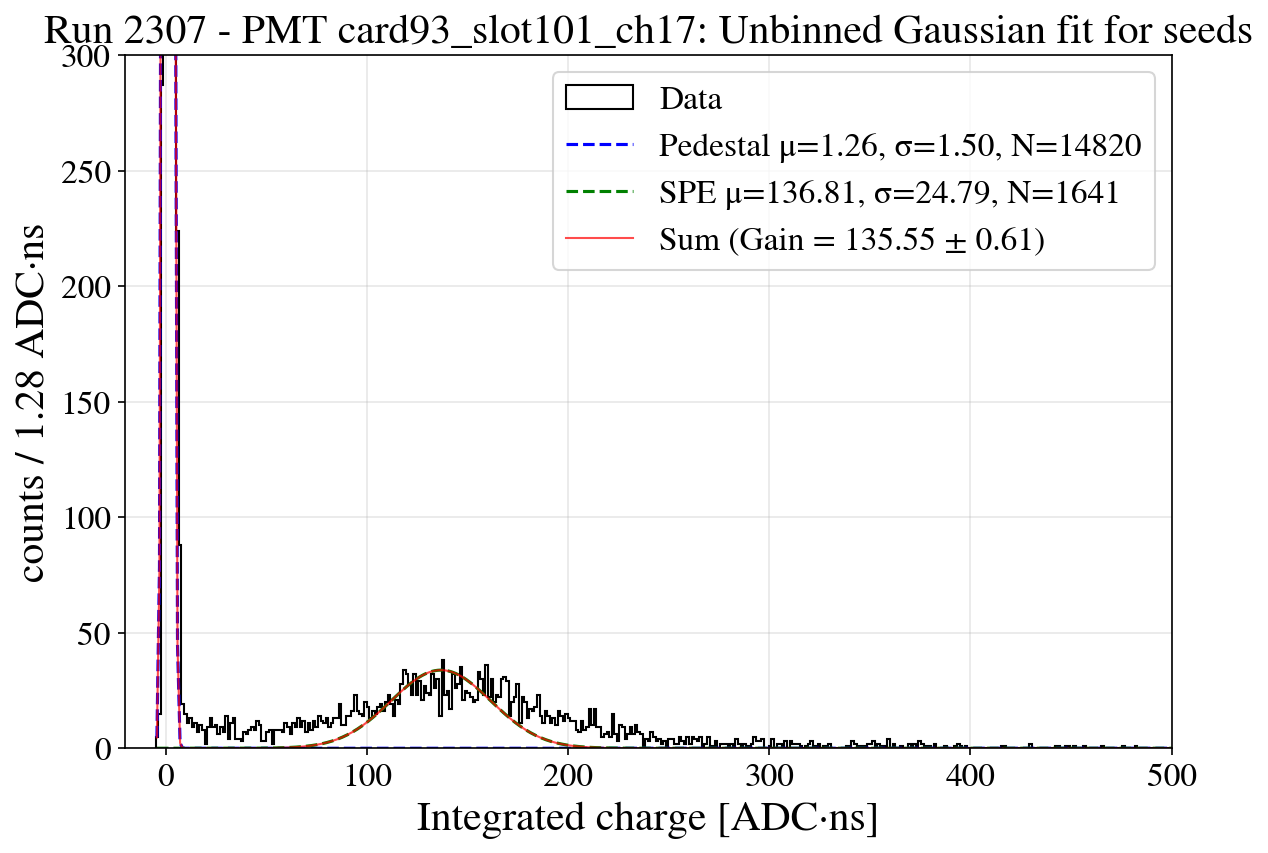


===== Pedestal Fit =====
μ₁  = 1.260  ADC·ns
σ₁  = 1.504  ADC·ns
N₁  = 14820 points

===== SPE Fit =====
μ₂  = 136.806  ADC·ns
σ₂  = 24.789  ADC·ns
N₂  = 1641 points

===== Gain =====
Gain = 135.55 ± 0.61  ADC·ns


In [335]:
seeds = fit_pedestal_and_spe(charges, label=f"PMT {pmt_label}", plot=True)

print("\n===== Pedestal Fit =====")
print(f"μ₁  = {seeds['pedestal']['mu']:.3f}  ADC·ns")
print(f"σ₁  = {seeds['pedestal']['sigma']:.3f}  ADC·ns")
print(f"N₁  = {seeds['n_ped']} points")

print("\n===== SPE Fit =====")
print(f"μ₂  = {seeds['spe']['mu']:.3f}  ADC·ns")
print(f"σ₂  = {seeds['spe']['sigma']:.3f}  ADC·ns")
print(f"N₂  = {seeds['n_spe']} points")

print("\n===== Gain =====")
print(f"Gain = {seeds['gain']:.2f} ± {seeds['err_gain']:.2f}  ADC·ns")

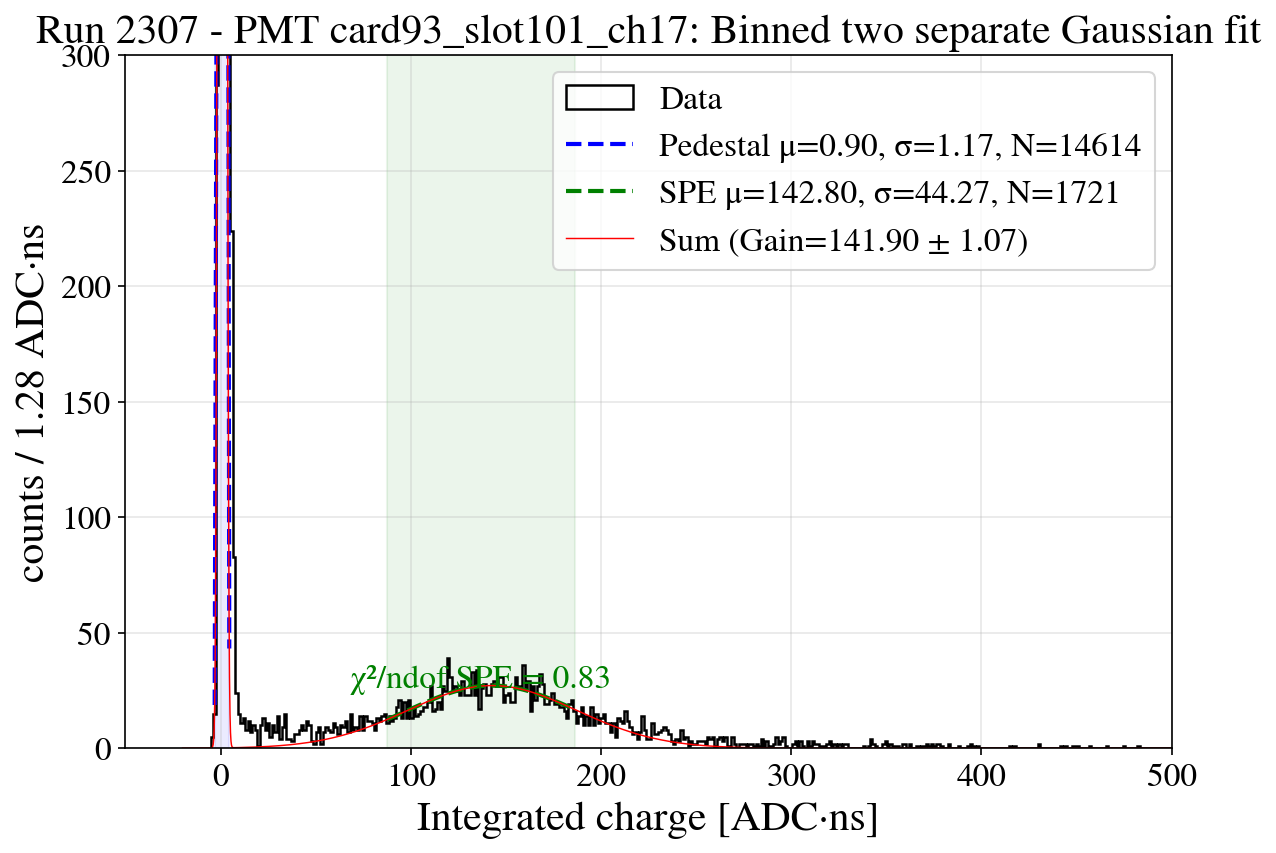


===== Pedestal Fit =====
μ₁  = 0.902  ADC·ns
σ₁  = 1.174  ADC·ns
N₁  = 14614 points
Fit region: -3.08 -> 4.59 ADC·ns

===== SPE Fit =====
μ₂  = 142.804  ADC·ns
σ₂  = 44.271  ADC·ns
N₂  = 1721 points
Fit region: 87.67 -> 186.09 ADC·ns
χ²/ndof = 0.83

===== Gain =====
Gain = 141.90 ± 1.07  ADC·ns


In [336]:
results = fit_and_plot_gaussians(charges, seeds, bins=500)

mu_ped, sigma_ped, A_ped = results['pedestal']
mu_spe, sigma_spe, A_spe, chi2ndof_spe = results['spe']
gain, err_gain = results['gain']
N_ped = results['N_ped']
N_spe = results['N_spe']

print("\n===== Pedestal Fit =====")
print(f"μ₁  = {mu_ped:.3f}  ADC·ns")
print(f"σ₁  = {sigma_ped:.3f}  ADC·ns")
print(f"N₁  = {N_ped} points")
print(f"Fit region: {results['ped_region'][0]:.2f} -> {results['ped_region'][1]:.2f} ADC·ns")

print("\n===== SPE Fit =====")
print(f"μ₂  = {mu_spe:.3f}  ADC·ns")
print(f"σ₂  = {sigma_spe:.3f}  ADC·ns")
print(f"N₂  = {N_spe} points")
print(f"Fit region: {results['spe_region'][0]:.2f} -> {results['spe_region'][1]:.2f} ADC·ns")
print(f"χ²/ndof = {chi2ndof_spe:.2f}")

print("\n===== Gain =====")
print(f"Gain = {gain:.2f} ± {err_gain:.2f}  ADC·ns")

# ANALYSIS AND PLOTS FOR ALL PMTs

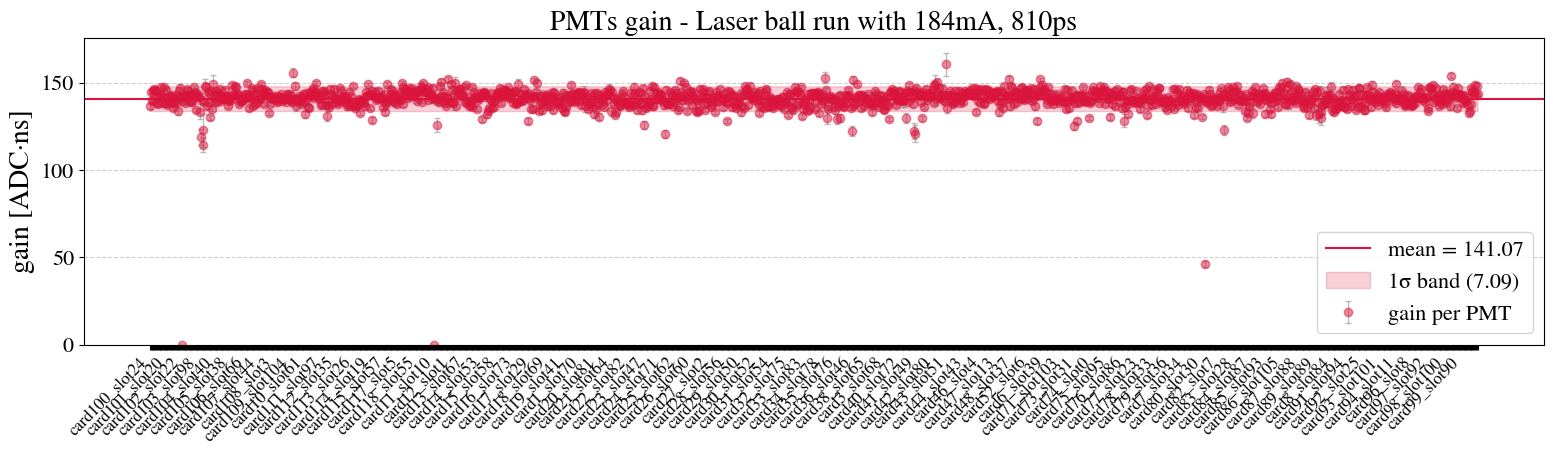

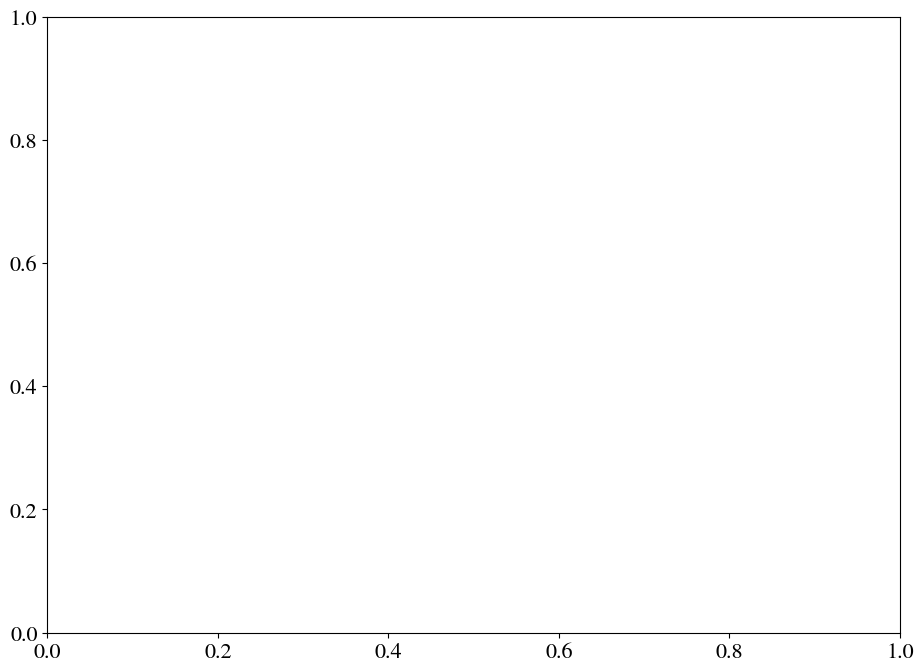

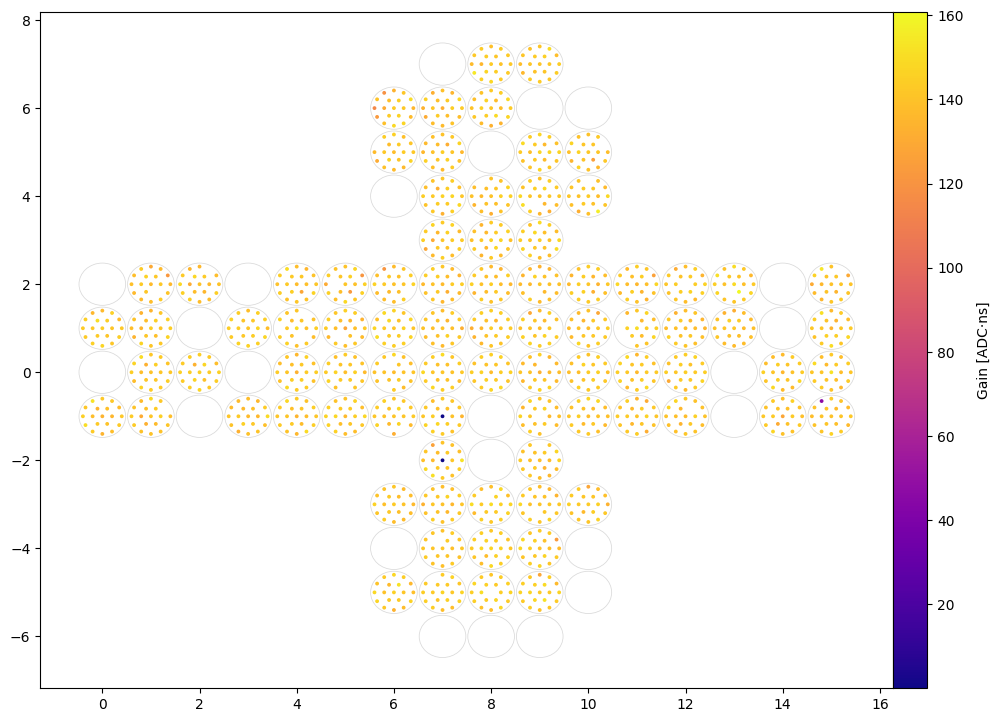

In [337]:
# load all npz
npz_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_MC-Data_Validation_with_GAIN_Calibration/"
n_chunks = 15  
npz_files = [f"{npz_dir}twoStepfit_run2307_v2_chunk{i}.npz" for i in range(n_chunks+1)]   

all_results_list = []
for npz_file in npz_files:
    data_chunk = np.load(npz_file)["results"]
    all_results_list.append(data_chunk)

# Concatante chunks
results = np.concatenate(all_results_list)

pmt_labels = []
x_labels = []
seen_mpmt = set()
for r in results:
    key = (r["card_id"], r["slot_id"])
    if key not in seen_mpmt:
        x_labels.append(f"card{r['card_id']}_slot{r['slot_id']}")
        seen_mpmt.add(key)
    else:
        x_labels.append("")
    pmt_labels.append(f"{r['card_id']}_{r['slot_id']}_{r['channel_id']}")

x = np.arange(len(pmt_labels))

# Gain and errors
gains = results["gain"].astype(float)
pedestal_sigma = results["pedestal_sigma"].astype(float)
spe_sigma = results["spe_sigma"].astype(float)
N_pedestal = results["N_pedestal"].astype(float)
N_spe = results["N_spe"].astype(float)

# Avoid division by 0
N_pedestal[N_pedestal == 0] = np.nan
N_spe[N_spe == 0] = np.nan

gain_errors = np.sqrt((pedestal_sigma/np.sqrt(N_pedestal))**2 + (spe_sigma/np.sqrt(N_spe))**2)

mask = np.isfinite(gains) & np.isfinite(gain_errors)
y_min = np.min(gains[mask] - gain_errors[mask]) * 0.95
y_max = np.max(gains[mask] + gain_errors[mask]) * 1.05

# Gain scatter plot
fig, ax = plt.subplots(figsize=(16,5))
color = "crimson"
marker_alpha = 0.5  #

eb = ax.errorbar(
    x, gains, yerr=gain_errors,
    fmt='o', color=color, ecolor='gray',
    elinewidth=1, capsize=2,
    alpha=marker_alpha, 
    label="gain per PMT"
)

mean_gain = np.nanmean(gains)
std_gain = np.nanstd(gains)

ax.axhline(mean_gain, color=color, lw=1.5, label=f"mean = {mean_gain:.2f}")
ax.fill_between(x, mean_gain-std_gain, mean_gain+std_gain, color=color, alpha=0.2,
                label=f"1σ band ({std_gain:.2f})")

ax.set_ylim(y_min, y_max)
ax.set_xticks(ticks=x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_ylabel("gain [ADC·ns]")
ax.set_title("PMTs gain - Laser ball run with 184mA, 810ps")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Initialization EventDisplay
wcte_event_display_path = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_2025_commissioning/2025_data/WCTE_event_display"
sys.path.append(wcte_event_display_path)

from EventDisplay import EventDisplay

ed = EventDisplay()
ed.load_mPMT_positions("mPMT_2D_projection_angles.csv")

gain_per_channel = np.full(ed.nChannels, np.nan)

for entry in results:
    card = int(entry['card_id'])
    slot = int(entry['slot_id'])
    ch   = int(entry['channel_id'])
    gain = float(entry['gain'])
    
    mPMT_id = slot
    idx = 19 * mPMT_id + ch
    if idx < ed.nChannels:
        gain_per_channel[idx] = gain

# Plot
fig, ax = plt.subplots(figsize=(11,8))
ed.plotEventDisplay(
    data=gain_per_channel,
    color_map=plt.cm.plasma,
    color_norm=colors.Normalize(vmin=np.nanmin(gain_per_channel), vmax=np.nanmax(gain_per_channel)),
    color_label="Gain [ADC·ns]",
    fig_width=11,
    show_zero=True,
    style=None
)
plt.tight_layout()
plt.show()
